## COVID19: SEIR Model with Vital Dynamics

The coronaviruses are a large family of viruses that appears in crown-like shape under the microscope and can cause a mild cold to severe respiratory disease. Some of the well-known coronaviruses are Middle East Respiratory Syndrome (MERS) and Severe Acute Respiratory Syndrome (SARS). And these viruses are notorious for their high transmissibility compared to other human influenza pathogens. The novel coronavirus (COVID-19) is now getting global attention because no medical practitioners know how severe the disease will be and how far it will spread. In this project, we will use **SEIR (S: Susceptible, E: Exposed, I: Infectious, and R: Removed)** model to forecast the total number of infected individuals in South Korea.

## Exploratory Data Analysis

### Import Modules

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

### Read Data

In [12]:
time_df = pd.read_csv("/Users/james/Desktop/BD-Compartmental-Model/Data/Time.csv", encoding = "UTF-8")
time_df.index = pd.to_datetime(time_df["date"])
time_df.drop("date", axis = 1, inplace=True)

time_province_df = pd.read_csv("//Users/james/Desktop/BD-Compartmental-Model/Data/TimeProvince.csv", encoding = "UTF-8")
time_province_df.index = pd.to_datetime(time_province_df["date"])
time_province_df.drop("date", axis = 1, inplace = True)

In [8]:
# Check if there is a null value in the dataset
print(all(time_df.isnull().sum() == 0) and 
      all(time_province_df.isnull().sum() == 0))

True


#### Plot Cumulative Cases in S.K.

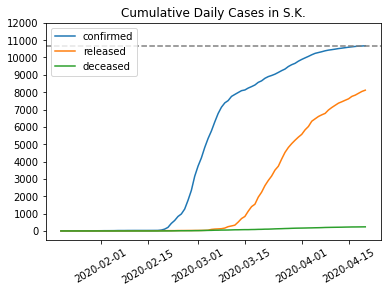

In [13]:
plt.plot(time_df[["confirmed", "released", "deceased"]])
plt.axhline(max(time_df["confirmed"]), color = "grey", linestyle="--")
plt.title("Cumulative Daily Cases in S.K.")
plt.legend(["confirmed", "released", "deceased"], loc = 2)
plt.yticks(np.arange(0, max(time_df["confirmed"]) * 1.2, 1000))
plt.xticks(rotation = 30)
plt.show()

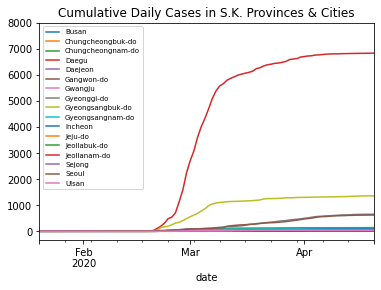

In [14]:
time_province_df.groupby("province")["confirmed"].plot(legend = True)
plt.title("Cumulative Daily Cases in S.K. Provinces & Cities")
plt.legend(fontsize = "x-small")
plt.yticks(np.arange(0, max(time_province_df["confirmed"]) * 1.3, 1000))
plt.show()

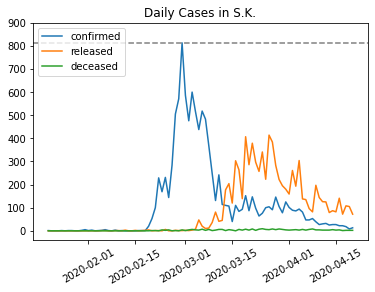

In [15]:
daily_time_df = time_df[["confirmed", "released", "deceased"]].diff().fillna(0)
daily_time_df.iloc[0, 0] = 1

plt.plot(daily_time_df[["confirmed", "released", "deceased"]])
plt.axhline(max(daily_time_df["confirmed"]), color = "grey", linestyle="--")
plt.title("Daily Cases in S.K.")
plt.legend(["confirmed", "released", "deceased"], loc = 2)
plt.yticks(np.arange(0, max(daily_time_df["confirmed"]) * 1.2, 100))
plt.xticks(rotation = 30)
plt.show()

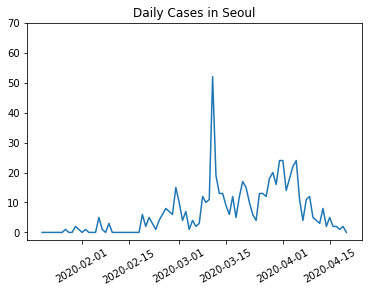

In [16]:
Seoul = time_province_df[time_province_df["province"] == "Seoul"][["confirmed"]].diff().fillna(0)

plt.plot(Seoul)
plt.title("Daily Cases in Seoul")
plt.yticks(np.arange(0, max(Seoul["confirmed"]) * 1.5, 10))
plt.xticks(rotation = 30)
plt.show()

In [36]:
# The percentage of confirmed cases in Seoul
perc_seoul = Seoul.loc["2020-04-10":,] * 100 / daily_time_df.loc["2020-04-10":,["confirmed"]]
print(np.mean(perc_seoul["confirmed"]))
print(np.std(perc_seoul["confirmed"]))

13.444559228650137
8.858712690536684


COVID-19 cases in South korea have dropped sharply since mid-march. <br>
But roughly 13% of the daily cases are coming from Seoul.

### SEIR-BD Model
$\frac{dS}{dt} = {\mu}N - vS - \frac{{\beta}SI}{N}$<font size=2>,  where ${\beta}$ is the infection rate.</font> <br><br>
$\frac{dE}{dt} = \frac{{\beta}SI}{N} - vE - {\sigma}E$ <font size=2>,  where ${\sigma}$ is the incubation rate.</font><br><br>
$\frac{dI}{dt} = {\sigma}E - {\gamma}I - vI$ <font size=2>,  where ${\gamma}$ is the recovery rate.</font><br><br>
$\frac{dR}{dt} = {\gamma}I - vR$ <br><br>
<font size=2>${\cdot}N = S + E + I + R$ is the total population.</font><br>
<font size=2>${\cdot}{\mu}$ and ${v}$ represent the birth and death rates respectively.</font>



### Set Parameters: <font color="red"> not reliable </font>

In [78]:
# R0 = Reproduction number is 2.2 

N = 51780579 # South Korea population 
mu = 1.58/150 # 0.92     # birth rate
nu = 0.0048/150 # 0.1      # death rate (random number for testing)
sigma = 1./4 # 1 / 5.2 # The mean average was 5.2 days (incubation period)
beta = 0.66 # 0.01   # transmission or contact rate (random number for testing)
gamma = 1./10 # 0.1   # recovery rate (random number for testing)
S0, E0, I0, R0 = N - 1, 1, 0, 0

In [79]:
# nu = death rate,  sigma = incubation rate,   beta = infection rate
# mu = birth rate,  gamma = recovery rate
def differentialEq(key_variable, t, N, beta, sigma, gamma, mu, nu):
    S, E, I, R = key_variable
    dSdt = mu * N - nu * S - beta * S * I / N
    dEdt = beta * S * I / N - nu * E - sigma * E
    dIdt = sigma * E - gamma * I - nu * I
    dRdt = gamma * I - nu * R
    return dSdt, dEdt, dIdt, dRdt

In [80]:
# Initial conditions vector
y0 = S0, E0, I0, R0
t = np.linspace(0, 150, 150)
# Integrate the SIR equations over the time grid, t.
ret = integrate.odeint(differentialEq, y0, t, args=(N, beta, sigma, gamma, mu, nu))
S, E, I, R = ret.T

In [81]:
S, E, I, R = ret.T

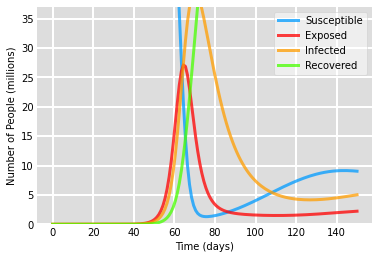

In [92]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000000, '#009BFF', alpha=0.75, lw=3, label='Susceptible')
ax.plot(t, E/1000000, '#FF0000', alpha=0.75, lw=3, label='Exposed')
ax.plot(t, I/1000000, '#FF9D00', alpha=0.75, lw=3, label='Infected')
ax.plot(t, R/1000000, '#48FF00', alpha=0.75, lw=3, label='Recovered')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number of People (millions)')
ax.set_ylim(0, 37)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

### Reference
**Fertility Rate & Population:** https://kosis.kr/eng/ <br>
**Incubation & Reproductive number:** https://www.nejm.org/doi/full/10.1056/NEJMoa2001316 <br>